In [1]:
import pandas as pd

In [2]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

In [4]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),  # Added the missing comma here
    ('payments.csv', 'payments'),
    ('geolocation.csv', 'geolocation')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='127.0.0.1',
    user='root',
    password='@UmaHustler019',
    database='ecommerce_target'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/UMA SHAW/OneDrive/ドキュメント/project intern'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
      # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")
    
   
    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector 

db_conn = mysql.connector.connect(host = "127.0.0.1",
                                 username = "root",
                                 password = '@UmaHustler019',
                                 database = "ecommerce_target")

cur = db_conn.cursor()



# 1.What are the top 10 cities with the highest number of customers

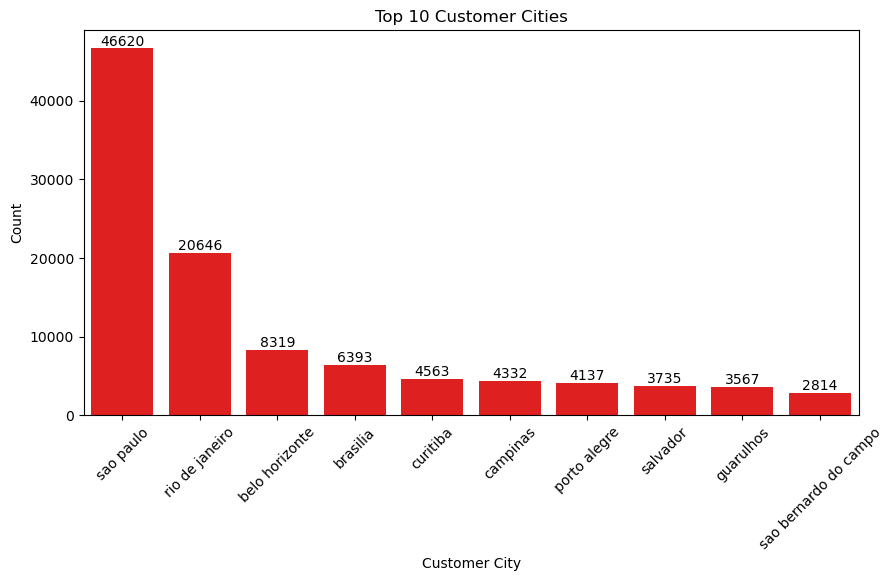

In [11]:
# Execute the query
query1 = "SELECT customer_city FROM customers"
cur.execute(query1)
data = cur.fetchall()

# Create DataFrame
df = pd.DataFrame(data, columns=["customer_city"])

# Get the top 10 customer cities
top_cities = df["customer_city"].value_counts().nlargest(10).index
top_cities_df = df[df["customer_city"].isin(top_cities)]

# Plot the count plot
plt.figure(figsize=(10, 5))
db = sns.countplot(x="customer_city", data=top_cities_df, order=top_cities,color="r")

# Add labels above each bar
db.bar_label(db.containers[0])
    
plt.title('Top 10 Customer Cities')
plt.xlabel('Customer City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 2.Count the number of orders placed in 2016, 2017 & 2018

In [13]:
# Define queries for each year
query_2016 = """SELECT COUNT(order_id) FROM orders
                WHERE year(order_purchase_timestamp) = 2016"""

query_2017 = """SELECT COUNT(order_id) FROM orders
                WHERE year(order_purchase_timestamp) = 2017"""

query_2018 = """SELECT COUNT(order_id) FROM orders
                WHERE year(order_purchase_timestamp) = 2018"""

# Execute queries and fetch results
cur.execute(query_2016)
orders_2016 = cur.fetchall()[0][0]

cur.execute(query_2017)
orders_2017 = cur.fetchall()[0][0]

cur.execute(query_2018)
orders_2018 = cur.fetchall()[0][0]

# Print results
print(f"Number of orders in 2016: {orders_2016}")
print()
print(f"Number of orders in 2017: {orders_2017}")
print()
print(f"Number of orders in 2018: {orders_2018}")

Number of orders in 2016: 987

Number of orders in 2017: 135303

Number of orders in 2018: 162033


# 3. Find the total sales per category.

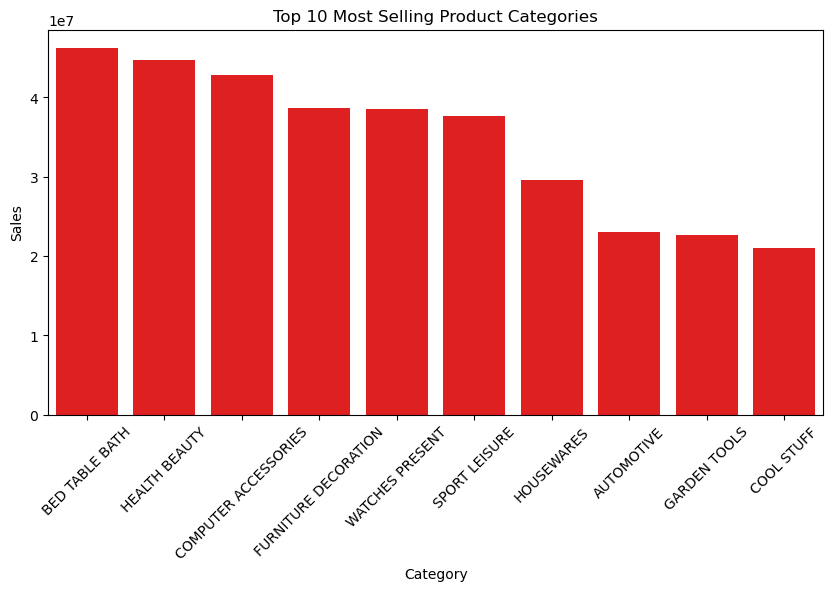

In [21]:
query3 = """SELECT 
    UPPER(products.product_category) AS category, 
    ROUND(SUM(payments.payment_value), 0) AS sales
FROM 
    products 
JOIN 
    order_items 
ON 
    products.product_id = order_items.product_id
JOIN 
    payments 
ON 
    payments.order_id = order_items.order_id
GROUP BY 
    category;

"""

cur.execute(query3)

data = cur.fetchall()

df = pd.DataFrame(data,columns =["category","sales"])
df.head(10)

# Sort by sales in descending order to get top selling categories
df = df.sort_values(by="sales", ascending=False).head(10)

# Plotting using Seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x='category', y='sales', data=df, color='r')

plt.xlabel('Category')
plt.ylabel('Sales')
plt.title('Top 10 Most Selling Product Categories')
plt.xticks(rotation=45)
plt.show()



# 4.  Calculate the percentage of orders that were paid in installments.

In [23]:
query4 = """SELECT (SUM(CASE WHEN payment_installments >=1 then 1 else 0 end))/COUNT(*)
* 100 FROM payments"""

cur.execute(query4)

data = cur.fetchall()

# Extract the percentage value
percentage_installments = data[0][0]

# Print the result
print(f"Percentage of orders with installments is approximately: {percentage_installments:.2f}%")


Percentage of orders with installments is approximately: 100.00%


# 5. Count the number of customers from each state. 

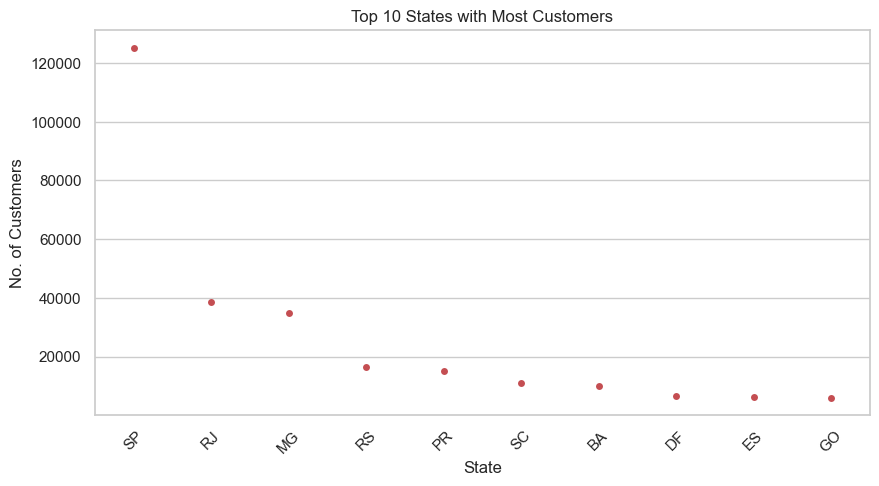

In [28]:
query5 = """SELECT count(customer_id) as count_of_customers , customer_state  FROM customers
group by customer_state ;"""

cur.execute(query5)

data = cur.fetchall()

#print(data)


df = pd.DataFrame(data, columns =["No.of Customers","State"])

# Sort the DataFrame by the number of customers and select the top 10
df = df.sort_values(by="No.of Customers", ascending=False).head(10)

# Plotting using Seaborn
plt.figure(figsize=(10, 5))
# use to set style of background of plot 
sns.set(style = 'whitegrid')
sns.swarmplot(x='State', y='No.of Customers', data=df, color='r')

plt.xlabel('State')
plt.ylabel('No. of Customers')
plt.title('Top 10 States with Most Customers')
plt.xticks(rotation=45)
plt.show()




# 6. The monthly distribution of orders in terms of count, for each month, for year 2018








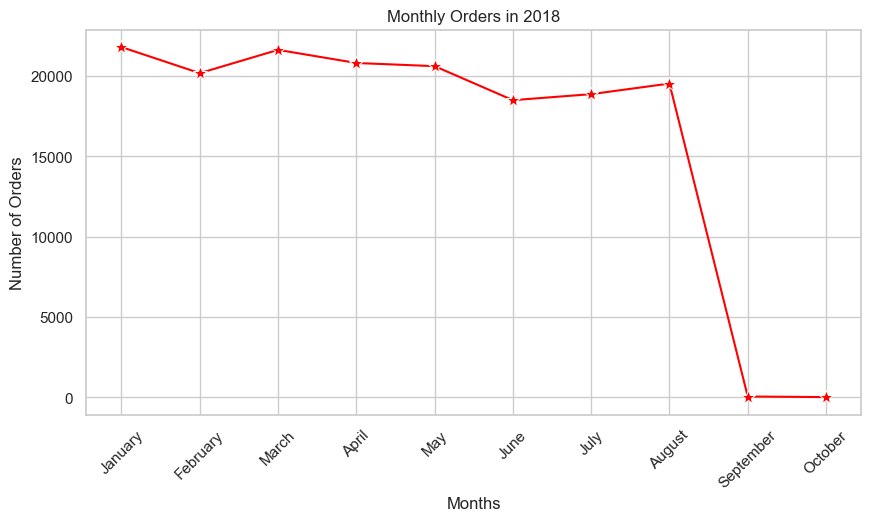

In [40]:


# Execute the corrected query
query6 = """
    SELECT MONTHNAME(order_purchase_timestamp) AS months, 
           COUNT(order_id) AS no_of_orders 
    FROM ecommerce_target.orders
    WHERE YEAR(order_purchase_timestamp) = 2018
    GROUP BY months;
"""
cur.execute(query6)
data = cur.fetchall()

# Create a DataFrame
df = pd.DataFrame(data, columns=["Months", "Orders_Count"])

# Ensure the months are in the correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['Months'] = pd.Categorical(df['Months'], categories=month_order, ordered=True)
df = df.sort_values('Months')

# Plotting using Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(x='Months', y='Orders_Count', data=df, color='red', marker='*', markersize=10)

plt.xlabel('Months')
plt.ylabel('Number of Orders')
plt.title('Monthly Orders in 2018')
plt.xticks(rotation=45)
plt.show()


# Find the average number of products per order, grouped by customer city.


In [2]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average No. of products"])

# Sort dataframe by 'average products' column in descending order and select top 10
df_sorted = df.sort_values(by='average No. of products', ascending=False).head(10)
df_sorted

,customer city,average No. of products
0,padre carvalho,63.00
1,celso ramos,58.50
2,datas,54.00
3,candido godoi,54.00
4,matias olimpio,45.00
5,cidelandia,36.00
6,curralinho,36.00
7,picarra,36.00
8,morro de sao paulo,36.00
9,teixeira soares,36.00


# 7.Calculate the percentage of total revenue contributed by each product category.

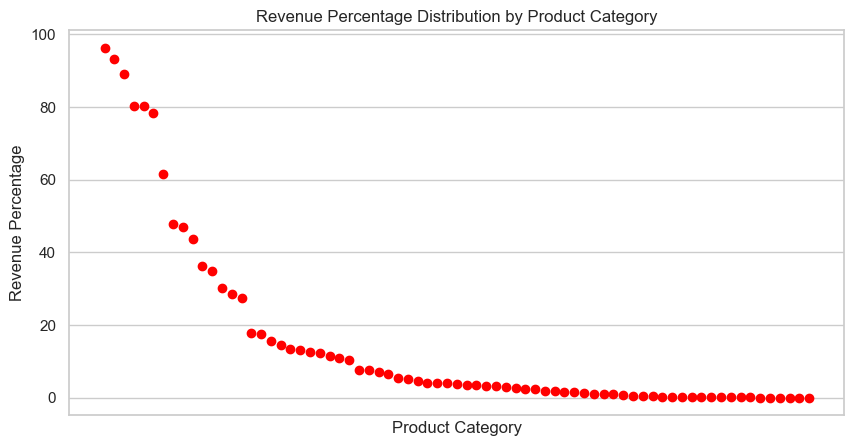

In [49]:
query7 = """
SELECT UPPER(p.product_category) AS category, 
       ROUND((SUM(pay.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100, 2) AS revenue_percentage
FROM products AS p
JOIN order_items AS o ON o.product_id = p.product_id
JOIN payments AS pay ON pay.order_id = o.order_id
GROUP BY category 
ORDER BY revenue_percentage DESC;
"""

cur.execute(query7)
data = cur.fetchall()

# Create a DataFrame
df = pd.DataFrame(data, columns=["Category", "percentage_distribution"])

# Convert the percentage_distribution to numeric
df['percentage_distribution'] = pd.to_numeric(df['percentage_distribution'], errors='coerce')

# Drop rows with NaN values if any
df = df.dropna()

# Plotting using Matplotlib directly for more control
plt.figure(figsize=(10, 5))
plt.scatter(df['Category'], df['percentage_distribution'], color='red', marker='o')

plt.xlabel('Product Category')
plt.ylabel('Revenue Percentage')
plt.title('Revenue Percentage Distribution by Product Category')

# Hide x-axis labels
plt.xticks([])

plt.show()


# 8. Identify the correlation between product price and the number of times a product has been purchased.

the correlation is -0.10631514167157562

[[ 1.         -0.10631514]
 [-0.10631514  1.        ]]


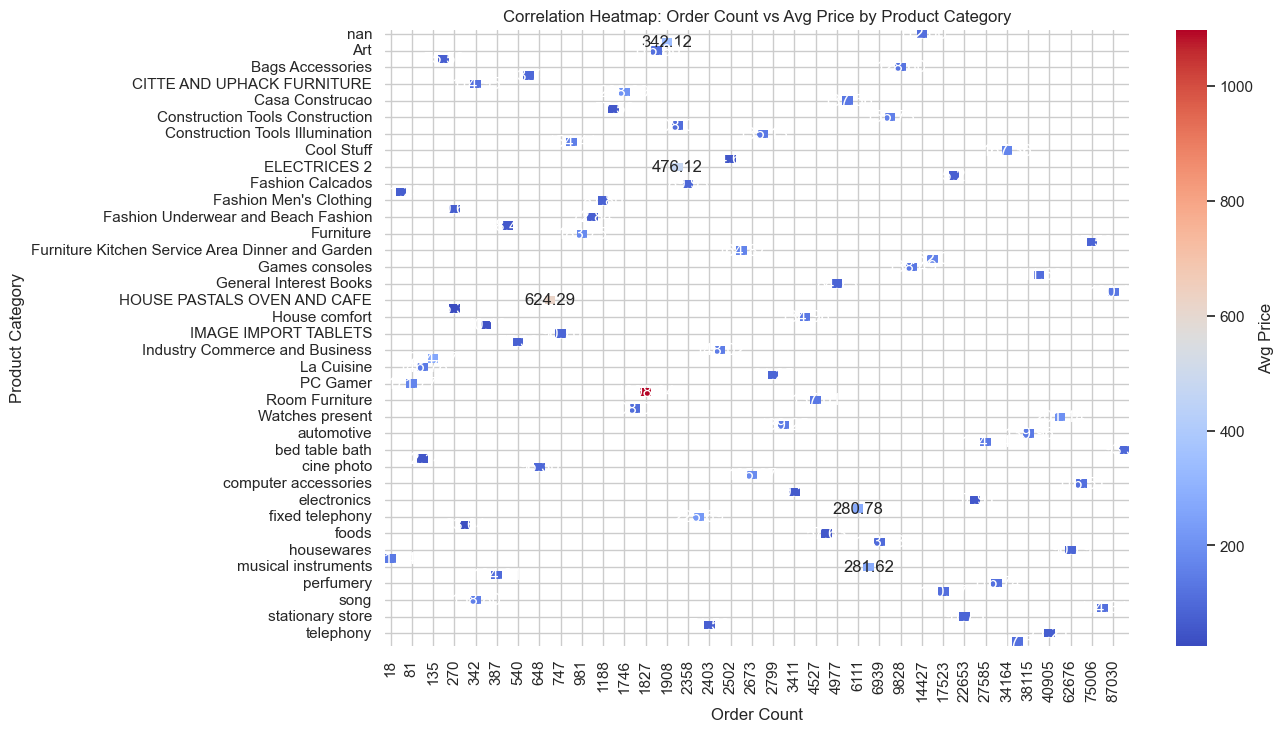

In [53]:
query8 = """

select p.product_category as category , count(o.product_id) as count , round(avg(o.price),2) as price FROM products as p
JOIN order_items as o
on o.product_id = p.product_id 
group by category ;

"""

cur.execute(query8)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "order_count", "price"])
arr1 = df["order_count"]
arr2 = df["price"]
a = np.corrcoef([arr1, arr2])
print("the correlation is", a[0][-1])
print()
print(a)
# Create pivot table for heatmap
heatmap_data = df.pivot(index='Category', columns='order_count', values='price')

# Plotting heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Avg Price'})

plt.title('Correlation Heatmap: Order Count vs Avg Price by Product Category')
plt.xlabel('Order Count')
plt.ylabel('Product Category')

plt.show()

# 9.Calculate the total revenue generated by each seller, and rank them by revenue.

In [19]:

query9 = """
SELECT 
    order_items.seller_id, 
    ROUND(SUM(payments.payment_value), 2) AS revenue, 
    DENSE_RANK() OVER (ORDER BY ROUND(SUM(payments.payment_value), 2) DESC) AS ranks
FROM 
    order_items 
JOIN 
    payments 
ON 
    order_items.order_id = payments.order_id 
GROUP BY 
    order_items.seller_id;

"""

cur.execute(query9)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["seller_id","revenue","rank"])
df.head(5)


,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,4564502.17,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,2773998.36,2
2,4a3ca9315b744ce9f8e9374361493884,2711207.43,3
3,1f50f920176fa81dab994f9023523100,2612280.78,4
4,53243585a1d6dc2643021fd1853d8905,2564127.72,5


# 10.Calculate the moving average of order values for each customer over their order history.

In [ ]:
query9 = """
SELECT customer_id, order_purchase_timestamp, payment,
       AVG(payment) OVER (PARTITION BY customer_id ORDER BY order_purchase_timestamp ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS avg_payment
FROM (
    SELECT o.order_purchase_timestamp, o.customer_id, p.payment_value AS payment
    FROM payments AS p
    JOIN orders AS o ON o.order_id = p.order_id
) AS a;


"""

cur.execute(query9)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["coutomer_id","order_purchased_time","payment","Avg_payment"])
df

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar plot for average payment
ax1.bar(df.index, df["Avg_payment"], color='red', width=0.4, label='Avg Payment', align='center')
ax1.set_xlabel('Index')
ax1.set_ylabel('Avg Payment', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Line plot for individual payment
ax2 = ax1.twinx()
ax2.plot(df.index, df["payment"], color='black', marker='o', linestyle='-', linewidth=2.0, label='Payment')
ax2.set_ylabel('Payment', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legend
plt.title('Average Payment vs Individual Payment')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 11.Calculate the cumulative sales per month for each year.

In [ ]:
query="""SELECT 
    years, 
    months, 
    sales, 
    SUM(sales) OVER (ORDER BY years, months) AS cumulative_sales
FROM (
    SELECT 
        YEAR(o.order_purchase_timestamp) AS years,
        MONTH(o.order_purchase_timestamp) AS months,
        ROUND(SUM(p.payment_value), 2) AS sales 
    FROM 
        orders AS o 
    JOIN 
        payments AS p ON o.order_id = p.order_id
    GROUP BY 
        years, months
    ORDER BY 
        years, months
) AS a; """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["year","month","sales","cummulative_sales"])
# Plotting histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='cumulative_sales', bins=20, kde=False, color='red')
plt.title('Histogram of Cumulative Sales')
plt.xlabel('Cumulative Sales')
plt.ylabel('Frequency')

# Plotting normalized curve
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df['cumulative_sales'], cumulative=True, color='black')
plt.title('Normalized Cumulative Sales Curve')
plt.xlabel('Cumulative Sales')
plt.ylabel('Cumulative Probability')

# Show plots
plt.tight_layout()
plt.show()
     

# 12.Calculate the year-over-year growth rate of total sales.

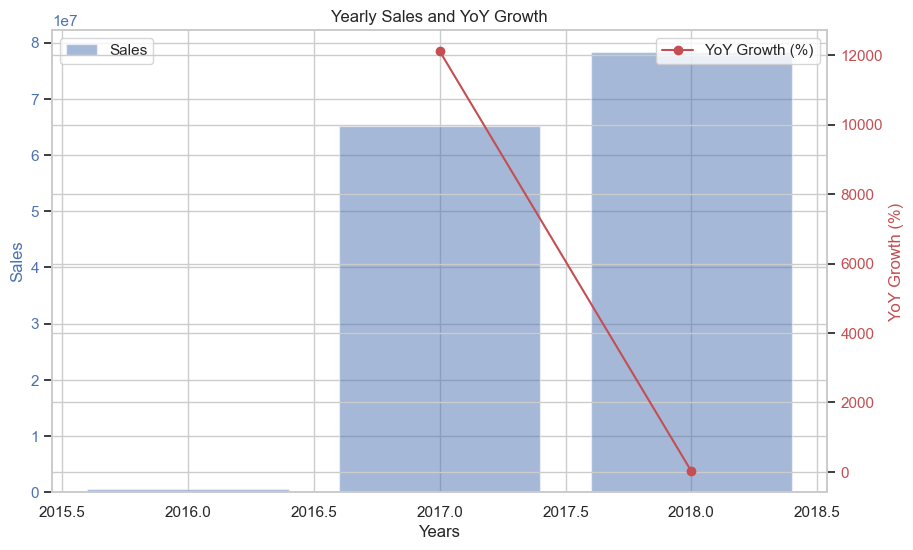

In [56]:
query11 = """
SELECT 
    years,
    sales,
    (sales - LAG(sales, 1) OVER (ORDER BY years)) / LAG(sales, 1) OVER (ORDER BY years) * 100 AS yoy_growth
FROM (
    SELECT 
        YEAR(o.order_purchase_timestamp) AS years,
        SUM(p.payment_value) AS sales
    FROM 
        payments AS p 
    JOIN 
        orders AS o ON o.order_id = p.order_id
    GROUP BY 
        YEAR(o.order_purchase_timestamp)
) AS yearly_sales;
"""

cur.execute(query11)
data = cur.fetchall()
df = pd.DataFrame(data)
df

# Create DataFrame from fetched data
df = pd.DataFrame(data, columns=["years", "sales", "yoy_growth"])

# Plotting dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot bar chart for sales on primary axis (left)
ax1.bar(df['years'], df['sales'], color='b', alpha=0.5, label='Sales')
ax1.set_xlabel('Years')
ax1.set_ylabel('Sales', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create secondary axis (right) for yoy_growth
ax2 = ax1.twinx()
ax2.plot(df['years'], df['yoy_growth'], color='r', marker='o', label='YoY Growth (%)')
ax2.set_ylabel('YoY Growth (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and legends
plt.title('Yearly Sales and YoY Growth')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# 12.Identify the top 3 customers who spent the most money in each year.

In [ ]:
query12 = """
SELECT 
    customer_id, 
    year, 
    total_spent
FROM (
    SELECT 
        customer_id, 
        year, 
        total_spent,
        DENSE_RANK() OVER (PARTITION BY year ORDER BY total_spent DESC) AS customer_rank
    FROM (
        SELECT 
            o.customer_id, 
            YEAR(o.order_purchase_timestamp) AS year, 
            SUM(p.payment_value) AS total_spent
        FROM 
            orders o
        JOIN 
            payments p ON o.order_id = p.order_id
        GROUP BY 
            o.customer_id, YEAR(o.order_purchase_timestamp)
    ) AS yearly_spending
) AS ranked_customers
WHERE customer_rank <= 3;
"""

cur.execute(query12)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["id","year","payment"])
#df = pd.DataFrame(data)
df
# Plotting bar plot with hue based on year
plt.figure(figsize=(10, 6))

sns.barplot(x='id', y='payment', hue='year', data=df, palette='Reds')

plt.title("Top 3 Customers' Total Spent by Year")
plt.xlabel('Customer ID')
plt.ylabel('Total Spent')
plt.legend(title='Year', loc='upper right')

# Rotate x-axis labels by 90 degrees for better readability
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
